In [1]:
import mlflow
import pickle
import sys
sys.path.insert(1, '../library')
import database_helper
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense
import seaborn as sns
import wrapt
print(tf.__version__)
print(wrapt.__version__)

2024-09-05 22:06:02.712170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 22:06:02.712529: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 22:06:02.714207: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-05 22:06:02.719354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 22:06:02.727625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

2.17.0
1.14.1


In [2]:
os.environ["MLFLOW_TRACKING_USERNAME"] = "user"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "password"
mlflow.set_tracking_uri(uri="http://mlflow.local:80")
mlflow.set_experiment("Multi-Output Time Series Forecast")
mlflow.autolog()
os.environ["WRAPT_DISABLE_EXTENSIONS"] = "True"


2024/09/05 22:06:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/09/05 22:06:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [3]:
with open('selected_columns.pkl', 'rb') as f:
    selected_columns = pickle.load(f)

strings_to_exclude = ['icon', 'moon', 'warning']
selected_columns = [item for item in selected_columns if not any(substring in item for substring in strings_to_exclude)]

strings_to_include = ['days_0', '10838']
selected_columns = [item for item in selected_columns if all(substring in item for substring in strings_to_include)]

print(str(len(selected_columns)) + ' Features selected')
df = database_helper.query_data(field_list=selected_columns)

9 Features selected
Executing Query 1 from 2024-07-28 12:00:00 to 2024-08-02 12:00:00
(43191, 17)
Executing Query 2 from 2024-08-02 12:00:00 to 2024-08-07 12:00:00
(43181, 17)
Executing Query 3 from 2024-08-07 12:00:00 to 2024-08-12 12:00:00
(43198, 17)
Executing Query 4 from 2024-08-12 12:00:00 to 2024-08-17 12:00:00
(43191, 17)
Executing Query 5 from 2024-08-17 12:00:00 to 2024-08-22 12:00:00
(43193, 17)
Executing Query 6 from 2024-08-22 12:00:00 to 2024-08-27 12:00:00
(43169, 17)
Executing Query 7 from 2024-08-27 12:00:00 to 2024-09-01 12:00:00
(43198, 17)
Executing Query 8 from 2024-09-01 12:00:00 to 2024-09-05 20:06:03
(37468, 17)


In [4]:
df.set_index('_time', inplace=True)
df = df.select_dtypes(include='float64')
df.interpolate(inplace=True)
df = df.resample('h').mean()
df.reset_index(inplace=True)
date_time = pd.to_datetime(df.pop('_time'), format='%d.%m.%Y %H:%M:%S')

display(df)
display(date_time)

,10838_days_0_precipitation,10838_days_0_sunrise,10838_days_0_sunset,10838_days_0_sunshine,10838_days_0_temperatureMax,10838_days_0_temperatureMin,10838_days_0_windDirection,10838_days_0_windGust,10838_days_0_windSpeed
0,59.000000,1.722139e+12,1.722193e+12,4610.000000,229.0,174.000000,3210.0,241.000000,93.0
1,59.000000,1.722139e+12,1.722193e+12,4610.000000,229.0,174.000000,3210.0,241.000000,93.0
2,59.000000,1.722139e+12,1.722193e+12,4610.000000,229.0,174.000000,3210.0,241.000000,93.0
3,59.000000,1.722139e+12,1.722193e+12,4610.000000,229.0,174.000000,3210.0,241.000000,93.0
4,60.338889,1.722139e+12,1.722193e+12,4598.416667,229.0,172.547222,3210.0,226.713889,93.0
...,...,...,...,...,...,...,...,...,...
940,25.711111,1.725511e+12,1.725559e+12,4122.333333,264.0,157.000000,860.0,317.788889,167.0
941,32.000000,1.725511e+12,1.725559e+12,4140.000000,264.0,157.000000,860.0,296.000000,167.0
942,32.000000,1.725511e+12,1.725559e+12,4140.000000,264.0,157.000000,860.0,296.000000,167.0
943,32.000000,1.725511e+12,1.725559e+12,4140.000000,264.0,157.000000,860.0,296.000000,167.0


0     2024-07-28 12:00:00+00:00
1     2024-07-28 13:00:00+00:00
2     2024-07-28 14:00:00+00:00
3     2024-07-28 15:00:00+00:00
4     2024-07-28 16:00:00+00:00
                 ...           
940   2024-09-05 16:00:00+00:00
941   2024-09-05 17:00:00+00:00
942   2024-09-05 18:00:00+00:00
943   2024-09-05 19:00:00+00:00
944   2024-09-05 20:00:00+00:00
Name: _time, Length: 945, dtype: datetime64[ns, UTC]

Text(0.5, 1.0, 'Time of day signal')

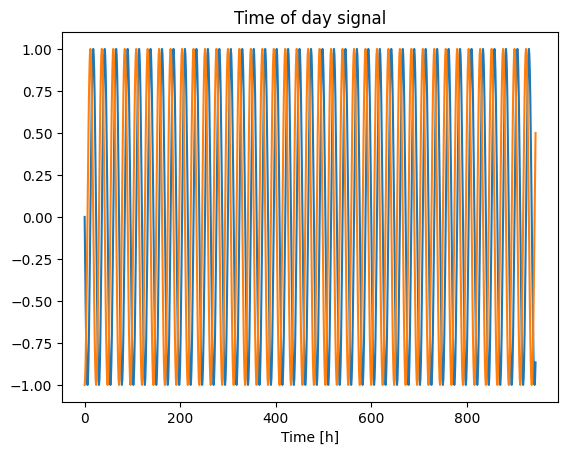

In [5]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
plt.plot(np.array(df['Day sin'])[:])
plt.plot(np.array(df['Day cos'])[:])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [9]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [12]:
time_range = 24
shift = 1
wide_window = WindowGenerator(input_width=time_range, label_width=time_range, shift=shift)
num_features = wide_window.train_df.shape[1]


In [13]:
print(wide_window.test_df.shape)
print(wide_window.train_df.shape)
print(wide_window.val_df.shape)

(95, 13)
(661, 13)
(189, 13)


In [14]:


# Define the model
model = Sequential()

neuron_amount = 32

# First LSTM layer, return_sequences=True to output the full sequence
model.add(LSTM(neuron_amount, return_sequences=True, input_shape=(time_range, num_features)))
# Second LSTM layer, return_sequences=True to keep the full sequence
model.add(LSTM(neuron_amount, return_sequences=True))
model.add(LSTM(neuron_amount, return_sequences=True))
model.add(LSTM(neuron_amount, return_sequences=True))
model.add(LSTM(neuron_amount, return_sequences=True))
# Dropout layer for regularization
model.add(Dropout(0.2))
# Final Dense layer to produce the same number of features for each time step
model.add(Dense(num_features))

model.summary()

/home/tobias/Projects/terraform-network-testbed/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 32)         │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24, 13)         │           429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,597 (154.68 KB)

 Trainable params: 39,597 (154.68 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])
  return history, model

In [16]:
history, model = compile_and_fit(model, wide_window)

val_performance = {}
performance = {}
val_performance['Residual LSTM'] = model.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = model.evaluate(wide_window.test, verbose=0, return_dict=True)

2024/09/05 22:06:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5fd6a6f374c74220bc749d313091b586', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024-09-05 22:06:12.817672: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-05 22:06:13.079502: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9871 - mean_absolute_error: 0.8659

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.9827 - mean_absolute_error: 0.8602 - val_loss: 2.2645 - val_mean_absolute_error: 1.2882
Epoch 2/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8618 - mean_absolute_error: 0.7943

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.8615 - mean_absolute_error: 0.7914 - val_loss: 1.9310 - val_mean_absolute_error: 1.2005
Epoch 3/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7738 - mean_absolute_error: 0.7303 

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.7752 - mean_absolute_error: 0.7289 - val_loss: 1.7253 - val_mean_absolute_error: 1.1344
Epoch 4/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7337 - mean_absolute_error: 0.7068

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.7345 - mean_absolute_error: 0.7053 - val_loss: 1.5324 - val_mean_absolute_error: 1.0674
Epoch 5/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7042 - mean_absolute_error: 0.6819

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.7062 - mean_absolute_error: 0.6809 - val_loss: 1.5291 - val_mean_absolute_error: 1.0539
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7011 - mean_absolute_error: 0.6744 - val_loss: 1.6549 - val_mean_absolute_error: 1.1321
Epoch 7/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6668 - mean_absolute_error: 0.6574

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.6686 - mean_absolute_error: 0.6563 - val_loss: 1.3882 - val_mean_absolute_error: 0.9972
Epoch 8/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6639 - mean_absolute_error: 0.6459

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6630 - mean_absolute_error: 0.6442 - val_loss: 1.3461 - val_mean_absolute_error: 0.9894
Epoch 9/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6316 - mean_absolute_error: 0.6346

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6314 - mean_absolute_error: 0.6330 - val_loss: 1.2774 - val_mean_absolute_error: 0.9565
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6226 - mean_absolute_error: 0.6269 - val_loss: 1.3243 - val_mean_absolute_error: 0.9637
Epoch 11/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6188 - mean_absolute_error: 0.6300

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.6188 - mean_absolute_error: 0.6289 - val_loss: 1.2228 - val_mean_absolute_error: 0.9323
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6165 - mean_absolute_error: 0.6250 - val_loss: 1.2521 - val_mean_absolute_error: 0.9426
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6021 - mean_absolute_error: 0.6083 - val_loss: 1.2897 - val_mean_absolute_error: 0.9654
Epoch 14/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5792 - mean_absolute_error: 0.5984

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.5802 - mean_absolute_error: 0.5969 - val_loss: 1.2282 - val_mean_absolute_error: 0.9349
Epoch 15/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5673 - mean_absolute_error: 0.5848

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5672 - mean_absolute_error: 0.5836 - val_loss: 1.2247 - val_mean_absolute_error: 0.9367
Epoch 16/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5469 - mean_absolute_error: 0.5779

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5474 - mean_absolute_error: 0.5767 - val_loss: 1.2133 - val_mean_absolute_error: 0.9304
Epoch 17/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5332 - mean_absolute_error: 0.5658

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.5335 - mean_absolute_error: 0.5642 - val_loss: 1.2007 - val_mean_absolute_error: 0.9247
Epoch 18/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5159 - mean_absolute_error: 0.5610

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.5173 - mean_absolute_error: 0.5598 - val_loss: 1.1881 - val_mean_absolute_error: 0.9200
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5066 - mean_absolute_error: 0.5495 - val_loss: 1.2073 - val_mean_absolute_error: 0.9290
Epoch 20/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5034 - mean_absolute_error: 0.5564

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.5052 - mean_absolute_error: 0.5562 - val_loss: 1.1829 - val_mean_absolute_error: 0.9154
Epoch 21/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5055 - mean_absolute_error: 0.5538 - val_loss: 1.2345 - val_mean_absolute_error: 0.9380
Epoch 22/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5090 - mean_absolute_error: 0.5615

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.5108 - mean_absolute_error: 0.5613 - val_loss: 1.1727 - val_mean_absolute_error: 0.9083
Epoch 23/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4991 - mean_absolute_error: 0.5525 - val_loss: 1.2256 - val_mean_absolute_error: 0.9389
Epoch 24/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4727 - mean_absolute_error: 0.5282

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.4722 - mean_absolute_error: 0.5262 - val_loss: 1.1893 - val_mean_absolute_error: 0.9236
Epoch 25/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4735 - mean_absolute_error: 0.5334

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4723 - mean_absolute_error: 0.5305 - val_loss: 1.1415 - val_mean_absolute_error: 0.8979
Epoch 26/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4409 - mean_absolute_error: 0.5062 - val_loss: 1.2509 - val_mean_absolute_error: 0.9555
Epoch 27/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4222 - mean_absolute_error: 0.4953

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.4247 - mean_absolute_error: 0.4955 - val_loss: 1.1236 - val_mean_absolute_error: 0.8879
Epoch 28/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4140 - mean_absolute_error: 0.4875 - val_loss: 1.2230 - val_mean_absolute_error: 0.9435
Epoch 29/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4040 - mean_absolute_error: 0.4863

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.4091 - mean_absolute_error: 0.4877 - val_loss: 1.1342 - val_mean_absolute_error: 0.8940
Epoch 30/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3952 - mean_absolute_error: 0.4740

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3974 - mean_absolute_error: 0.4746 - val_loss: 1.1284 - val_mean_absolute_error: 0.8930
Epoch 31/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4064 - mean_absolute_error: 0.4843 - val_loss: 1.1428 - val_mean_absolute_error: 0.9001
Epoch 32/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3956 - mean_absolute_error: 0.4727

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.3967 - mean_absolute_error: 0.4721 - val_loss: 1.1063 - val_mean_absolute_error: 0.8788
Epoch 33/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3966 - mean_absolute_error: 0.4713 - val_loss: 1.1979 - val_mean_absolute_error: 0.9268
Epoch 34/50
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3703 - mean_absolute_error: 0.4560

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.3717 - mean_absolute_error: 0.4561 - val_loss: 1.0893 - val_mean_absolute_error: 0.8675
Epoch 35/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3529 - mean_absolute_error: 0.4439 - val_loss: 1.1359 - val_mean_absolute_error: 0.8951
Epoch 36/50
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3375 - mean_absolute_error: 0.4360

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.3404 - mean_absolute_error: 0.4359 - val_loss: 1.1060 - val_mean_absolute_error: 0.8712
Epoch 37/50
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3304 - mean_absolute_error: 0.4331

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3341 - mean_absolute_error: 0.4343 - val_loss: 1.1034 - val_mean_absolute_error: 0.8737
Epoch 38/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3351 - mean_absolute_error: 0.4346 - val_loss: 1.1149 - val_mean_absolute_error: 0.8709
Epoch 39/50
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3316 - mean_absolute_error: 0.4373

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.3357 - mean_absolute_error: 0.4382 - val_loss: 1.0942 - val_mean_absolute_error: 0.8683
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


2024/09/05 22:07:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run orderly-wolf-493 at: http://mlflow.local:80/#/experiments/4/runs/5fd6a6f374c74220bc749d313091b586.
2024/09/05 22:07:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow.local:80/#/experiments/4.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0374 - mean_absolute_error: 0.8288 


In [17]:
model.export('../docker/waether-timeseries-forecasts')

INFO:tensorflow:Assets written to: ../docker/waether-timeseries-forecasts/assets


INFO:tensorflow:Assets written to: ../docker/waether-timeseries-forecasts/assets


Saved artifact at '../docker/waether-timeseries-forecasts'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 13), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 24, 13), dtype=tf.float32, name=None)
Captures:
  136761064638800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064640144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064640912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064639184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064641296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064641104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064640528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064643216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064643984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136761064644944: TensorSpec(shape=(), dtype=tf.resource, name=

In [18]:
input_data_df = wide_window.test_df[:time_range]
true_data_df = wide_window.test_df[time_range:2*time_range]
true_data_df.reset_index(drop=True, inplace=True)

input_data = np.reshape(input_data_df, (1, time_range, num_features))
predictions = model.predict(input_data)
predictions_df = pd.DataFrame(predictions[0])
predictions_df.columns = true_data_df.columns

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


In [19]:

def compare_actual_vs_predicted(df_actual, df_predicted):
    columns = df_actual.columns  # Get the column names
    num_columns = len(columns)

    # Calculate the number of rows needed (2 columns per row)
    ncols = 2
    nrows = (num_columns + 1) // ncols  # Ensure enough rows

    # Adjust the figure size (width, height per plot)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
    
    # Flatten axes to make iteration easier, in case there's more than one row
    axes = axes.flatten()

    # Iterate through each column
    for i, col in enumerate(columns):
        sns.lineplot(ax=axes[i], x=df_actual.index, y=df_actual[col], label='Actual', color='blue')
        sns.lineplot(ax=axes[i], x=df_predicted.index, y=df_predicted[col], label='Predicted', color='orange')
        axes[i].set_title(f'Actual vs Predicted for {col}')
        axes[i].legend()

    # Remove any unused axes if the number of columns isn't divisible by 2
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])


    plt.tight_layout()
    plt.show()

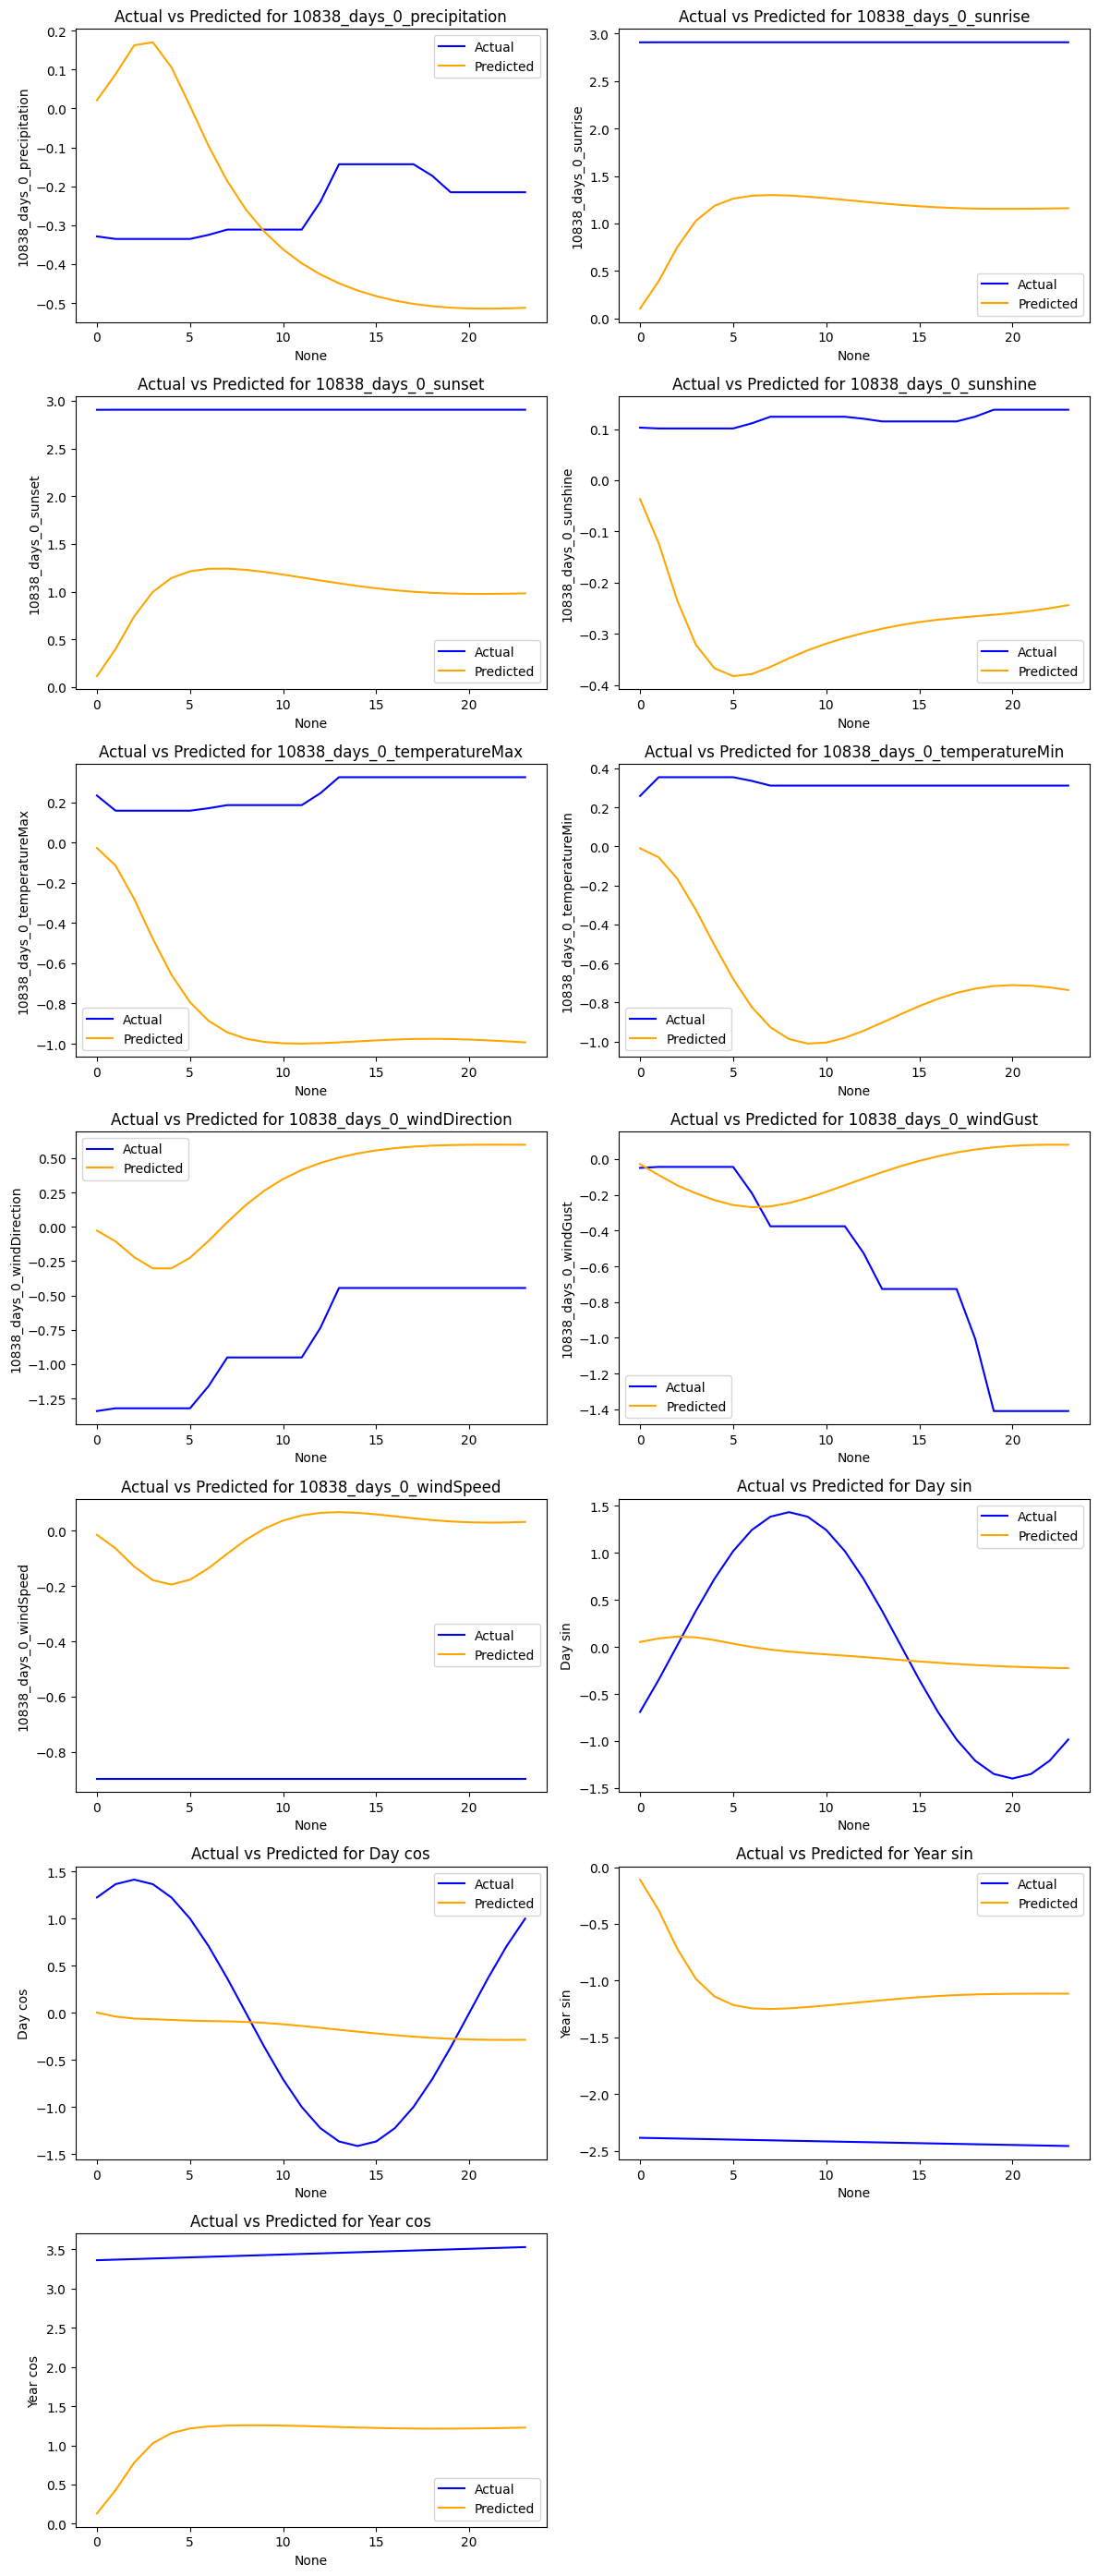

In [20]:
compare_actual_vs_predicted(true_data_df, predictions_df)